## Import libraries

In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## Define how operators work in the following class

In [3]:
class Operator(object):
    
    VERTICAL = 'v'
    HORIZONTAL = 'h'
    
    @staticmethod
    def sobel(image):
        kernel_v = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
        kernel_h = np.flip(kernel_v.T, axis=1)
        operator = Operator("Sobel", kernels={
            Operator.VERTICAL: kernel_v,
            Operator.HORIZONTAL: kernel_h})
        operator.filter_(image)
        return operator
    
    @staticmethod
    def prewitt(image):
        kernel_v = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
        kernel_h = np.flip(kernel_v.T, axis=1)
        operator = Operator("Prewitt", kernels={
            Operator.VERTICAL: kernel_v,
            Operator.HORIZONTAL: kernel_h})
        operator.filter_(image)
        return operator
    
    @staticmethod
    def scharr(image):
        kernel_v = np.array([[47, 0, -47], [162, 0, -162], [47, 0, -47]])
        kernel_h = np.flip(kernel_v.T, axis=1)
        operator = Operator("Scharr", kernels={
            Operator.VERTICAL: kernel_v,
            Operator.HORIZONTAL: kernel_h})
        operator.filter_(image)
        return operator

    def __init__(self, name, kernels={}):
        self.name = name
        self.kernels = kernels
        self.outputs = {}
        
    def filter_(self, image, convolution=False):
        image_row, image_col = image.shape
        
        for orientation, kernel in self.kernels.items():
            kernel_row, kernel_col = kernel.shape

            output = np.zeros(image.shape)

            pad_height = int((kernel_row - 1) / 2)
            pad_width = int((kernel_col - 1) / 2)

            padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))

            padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image

            if convolution:
                kernel = np.rot90(kernel, 2)

            for row in range(image_row):
                for col in range(image_col):
                    output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
                    
            self.outputs[orientation] = output
    
    def gradient_magnitude(self):
        if self.outputs:
            output = np.zeros(self.outputs[list(self.outputs.keys())[0]].shape)
            for orientation, image in self.outputs.items():
                output += np.square(image)
                output *= 255.0 / output.max()
            return np.sqrt(output)
        return None

In [11]:
operator = Operator("Laplace", kernels={None: np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])})
image = np.array([
    [10, 140, 0, 10],
    [120, 15, 10, 20],
    [10, 130, 10, 190],
    [20, 40, 170, 30]])
operator.filter_(image)
print("Cross correlation H ⨂ ω:")
print(operator.outputs[None])
a = operator.outputs[None]
c = (255*(a - np.min(a))/np.ptp(a)).astype(int)
print(c)
a = image-c
c = (255*(a - np.min(a))/np.ptp(a)).astype(int)
print(a)
print(c)


Cross correlation H ⨂ ω:
[[ 220. -535.  160.  -20.]
 [-445.  340.    5.  130.]
 [ 230. -445.  460. -700.]
 [ -30.  160. -600.  240.]]
[[202  36 189 149]
 [ 56 228 154 182]
 [204  56 255   0]
 [147 189  21 206]]
[[-192  104 -189 -139]
 [  64 -213 -144 -162]
 [-194   74 -245  190]
 [-127 -149  149 -176]]
[[ 31 204  32  62]
 [181  18  59  48]
 [ 29 187   0 255]
 [ 69  56 230  40]]


## Use an example

In [3]:
operator = Operator("Custom", kernels={None: np.array([[-10, -10, 0], [-10, 0, 10], [0, 10, 10]])})
image = np.array([
    [10, 20, 0, 30],
    [20, 0, 10, 20],
    [10, 0, 40, 10],
    [20, 40, 0, 30]])

operator.filter_(image)
print("Cross correlation H ⨂ ω:")
print(operator.outputs[None])

operator.filter_(image, convolution=True)
print("Convolution H ∗ ω:")
print(operator.outputs[None])


Cross correlation H ⨂ ω:
[[ 400.    0.  400.  200.]
 [   0.    0.  500. -300.]
 [ 400.  500.  300. -400.]
 [ 300. -300. -500. -500.]]
Convolution H ∗ ω:
[[-400.    0. -400. -200.]
 [   0.    0. -500.  300.]
 [-400. -500. -300.  400.]
 [-300.  300.  500.  500.]]


## Use a grayscaled image

Image size:
(640, 600)


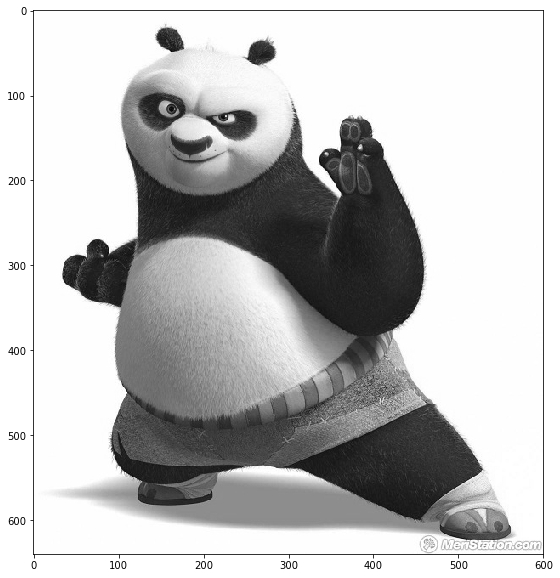

In [4]:
image = np.array(Image.open('KungFuPanda.png').convert('L'))
print("Image size:")
print(image.shape)
fig = plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.show()

## Edge detection with Sobel, Scharr and Prewitt operators

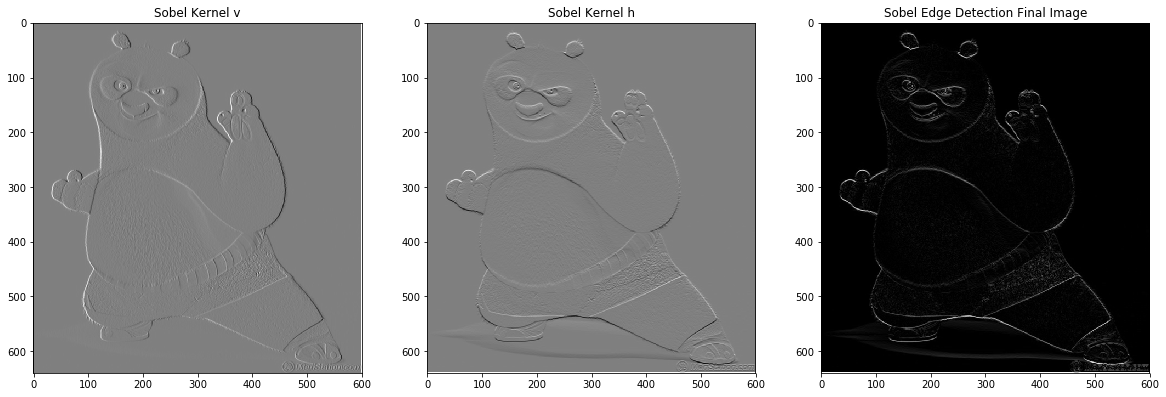

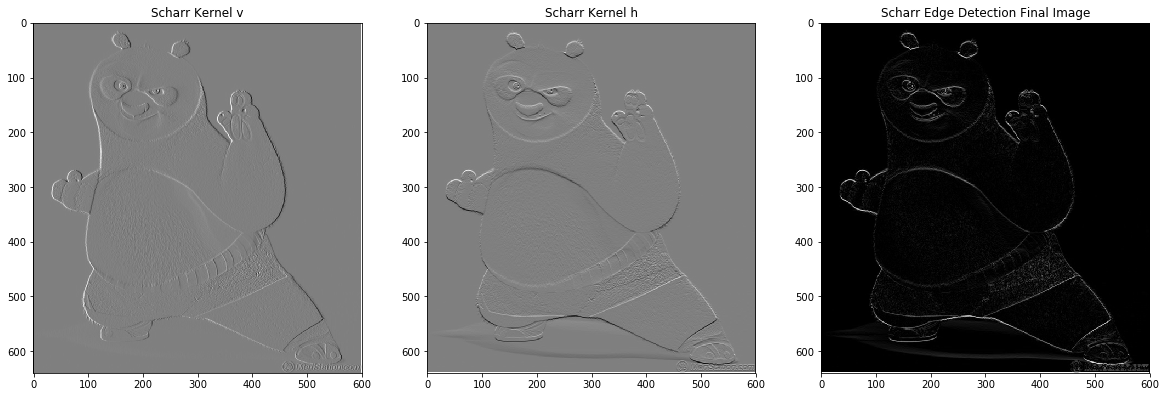

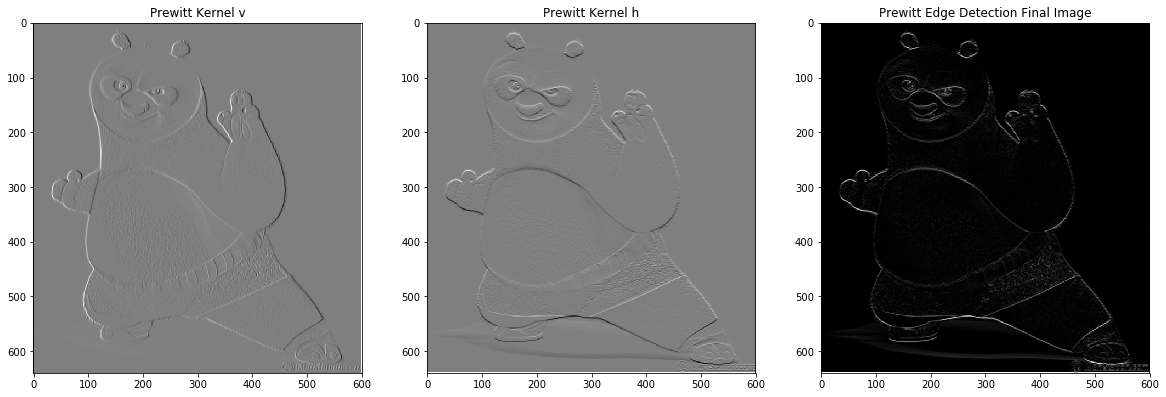

In [5]:
operators = [Operator.sobel(image), Operator.scharr(image), Operator.prewitt(image)]
for operator in operators:
    fig = plt.figure(figsize=(20, 60))
    fig.add_subplot(1, 3, 1)
    plt.imshow(operator.outputs[Operator.VERTICAL], cmap='gray')
    plt.title("{} Kernel {}".format(operator.name, Operator.VERTICAL))
    fig.add_subplot(1, 3, 2)
    plt.imshow(operator.outputs[Operator.HORIZONTAL], cmap='gray')
    plt.title("{} Kernel {}".format(operator.name, Operator.HORIZONTAL))
    fig.add_subplot(1, 3, 3)
    plt.imshow(operator.gradient_magnitude(), cmap='gray')
    plt.title("{} Edge Detection Final Image".format(operator.name))
    plt.show()

## Edge Detection with Canny

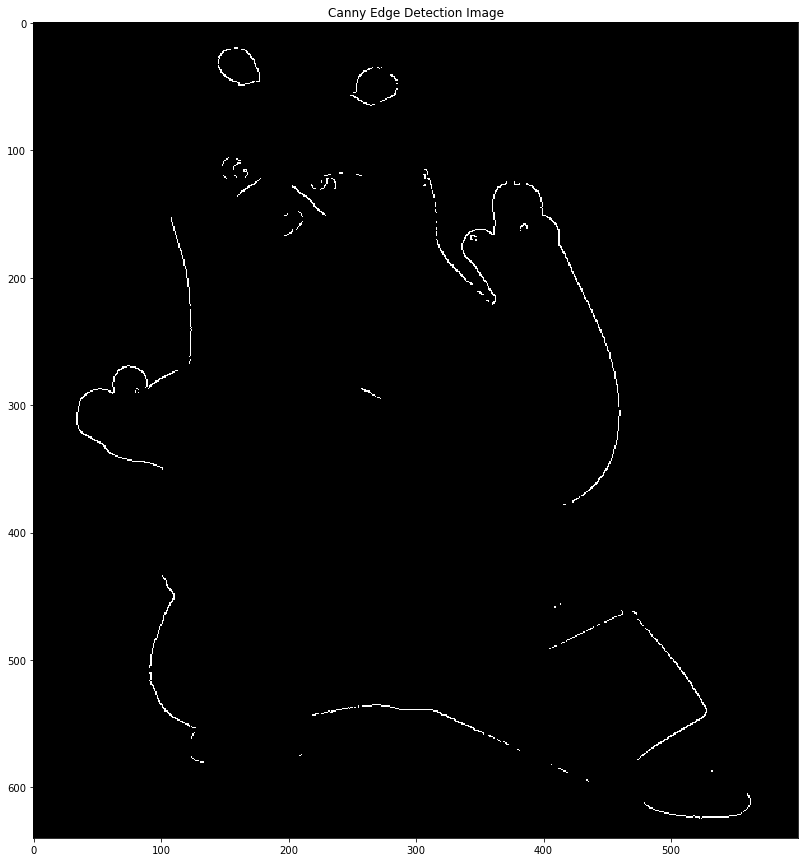

In [6]:
canny = cv2.Canny(image, image.shape[0], image.shape[1])
fig = plt.figure(figsize=(15, 15))
plt.imshow(canny, cmap='gray')
plt.title("Canny Edge Detection Image")
plt.show()

## Gradient vector drawing

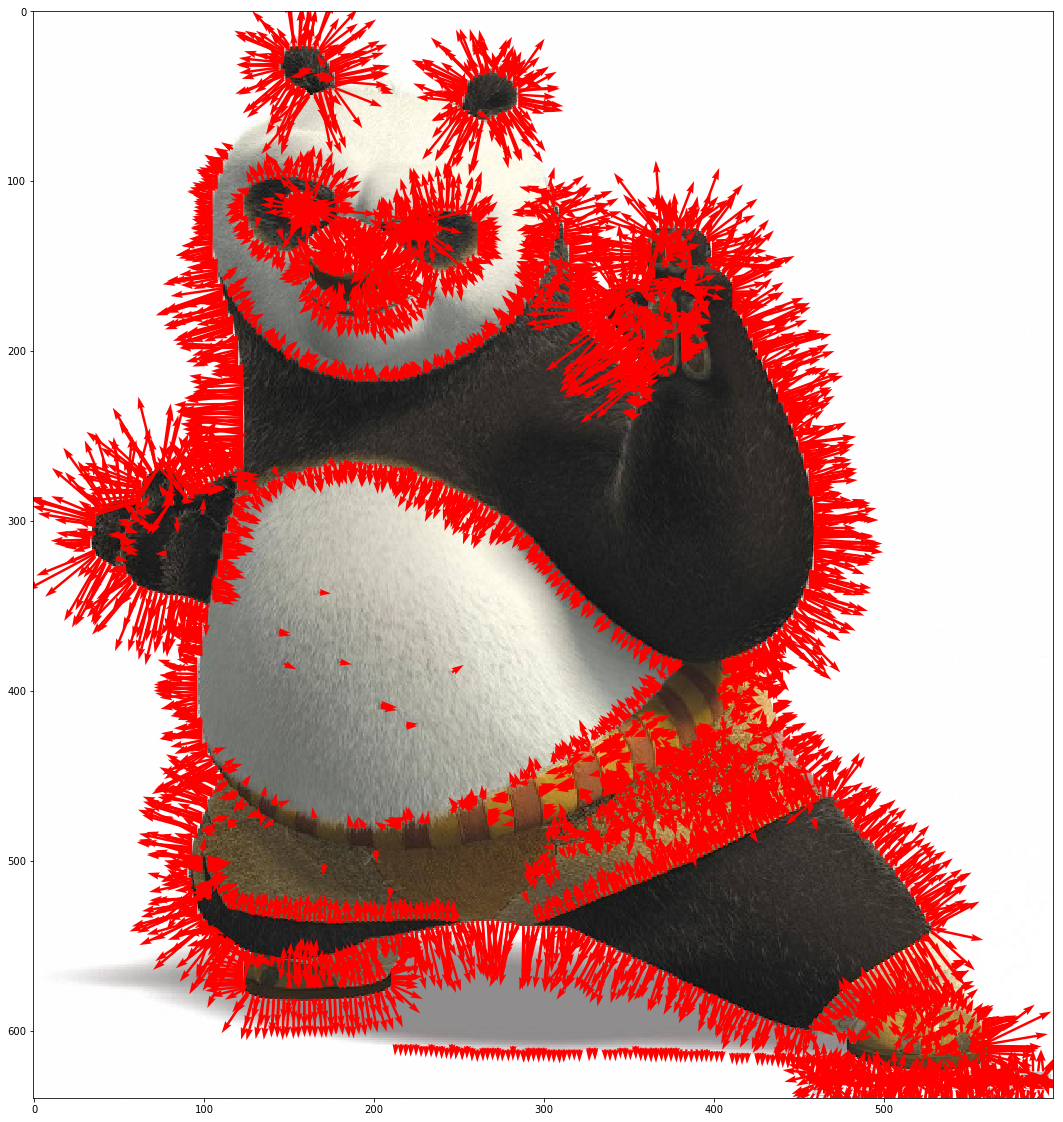

In [7]:
# Use Sobel operator
sobel = operators[0]

draw_every = 3
thres = 130

origin_x = []
origin_y = []
vector_x = []
vector_y = []
i = 0
for row in range(image.shape[0]):
    for col in range(image.shape[1]):
        
        # Using negatives to point to other direction
        x = -sobel.outputs[Operator.VERTICAL][row, col]
        y = -sobel.outputs[Operator.HORIZONTAL][row, col]
        
        # Draw vector every "draw_every" times, if vector > threshold and is not the contour
        if not i % draw_every and (abs(x) > thres or abs(y) > thres) and row and row+1 < image.shape[0] and col and col+1 < image.shape[1]:
            origin_x.append(col)
            origin_y.append(row)
            vector_x.append(x)
            vector_y.append(y)
        i += 1

fig = plt.figure(figsize=(20, 20))
plt.imshow(np.array(Image.open('KungFuPanda.png')))
plt.quiver(origin_x, origin_y, vector_x, vector_y, angles='xy', scale_units='xy', scale=20, color='r')
plt.show()